In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd /content/drive/MyDrive/Stopień_2/Semestr_2/DNN

In [3]:
# !pip install wfdb PyWavelets --quiet
import gc
import numpy as np
import pywt
import matplotlib.pyplot as plt
import json

In [4]:
def create_ann_mask(ann, signal_len):
    label = np.zeros((signal_len,1), dtype=bool)
    aux_notes = ann.aux_note
    samples = np.append(ann.sample, signal_len)
    aux_notes.append('END')
    start = 0
    is_afib = False
    for i, note in enumerate(aux_notes):
        if note == '(AFIB':
            is_afib = True
            start = samples[i]
        elif note != '' and is_afib:
            end = samples[i]
            label[start:end] = True
            is_afib = False
    return label

In [5]:
def denoise_ecg(signal, wavelet='db4', level=4, thresholding='soft'):
    """
    Denoise an ECG signal using Discrete Wavelet Transform (DWT).

    Parameters:
    - signal: 1D NumPy array, the ECG signal to denoise.
    - wavelet: str, the wavelet type (default: 'db4').
    - level: int, the level of decomposition (default: 4).
    - thresholding: str, 'soft' or 'hard' thresholding (default: 'soft').

    Returns:
    - denoised_signal: 1D NumPy array, the denoised ECG signal.
    """
    # Perform DWT decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Estimate a universal threshold based on noise variance
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))

    # Apply thresholding to detail coefficients
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode=thresholding)

    # Reconstruct the signal using inverse DWT
    denoised_signal = pywt.waverec(coeffs, wavelet)[:len(signal)]
    return denoised_signal

In [6]:
import wfdb.processing
from tqdm.notebook import tqdm
import os
import numpy as np

TARGET_FS = 128
SEGMENT_LENGTH = 1024 * 2
AFIB_CLASSIFICATION_THRESHOLD = 0.5
TOTAL_DB_CHUNKS = 1

DB_PATH = 'AF_long'
OUTPUT_DIR = 'Dataset2'
DB_CODE = 'AF_long'

RECORDS_LEFT_FOR_VALIDATION = 4

EXCLUDED_RECORDS = ['00735', '03665']
record_names = np.loadtxt(os.path.join(DB_PATH, 'RECORDS'), dtype=str)
record_names = list(filter(lambda x: x not in EXCLUDED_RECORDS, record_names))

with open(os.path.join(OUTPUT_DIR, 'metadata/validation_records.txt'), 'a') as file:
  for record_name in record_names[-RECORDS_LEFT_FOR_VALIDATION:]:
        record_path = os.path.join(DB_PATH, record_name)
        file.write(record_path + '\n')


In [8]:
def preprocess_database_chunk(chunk_number, total_chunks = TOTAL_DB_CHUNKS):
  X_Afib = None
  Y_Afib = None
  X_Normal = None
  Y_Normal = None
  # main preprocessing loop
  print(f'processing chunk {chunk_number}/{TOTAL_DB_CHUNKS}')
  with tqdm(total=len(record_names)-RECORDS_LEFT_FOR_VALIDATION, desc="Processing") as pbar:
    for record_name in record_names[chunk_number:-RECORDS_LEFT_FOR_VALIDATION:total_chunks]:
        record_path = os.path.join(DB_PATH, record_name)
        # loading
        sig, fields = wfdb.rdsamp(record_path)
        sig_chan = sig.shape[1]
        fs = fields['fs']
        ann = wfdb.rdann(record_path, 'atr')
        # resampling if necessary
        if fs != TARGET_FS:
          sig, ann = wfdb.processing.resample_multichan(sig, ann, fs, TARGET_FS, resamp_ann_chan=1)
        # denoising
        sig_len = sig.shape[0]
        sig[:,0] = denoise_ecg(sig[:,0])
        sig[:,1] = denoise_ecg(sig[:,1])
        # normalizing
        sig = wfdb.processing.normalize_bound(sig)
        # creating mask
        ann = create_ann_mask(ann, sig_len)
        # segmenting
        record_crop = sig_len - sig_len % SEGMENT_LENGTH
        segment_shape = (sig_chan * (sig_len // SEGMENT_LENGTH), SEGMENT_LENGTH)
        ann = np.tile(ann, (1, sig_chan))
        sig = sig[:record_crop, :].T
        sig = sig.reshape(segment_shape)
        ann = ann[:record_crop, :].T
        ann = ann.reshape(segment_shape)
        # splitting into "classes"
        cond = np.sum(ann, axis = 1) >= SEGMENT_LENGTH * AFIB_CLASSIFICATION_THRESHOLD
        ann_Afib = ann[cond, :]
        sig_Afib = sig[cond, :]
        ann_Normal = ann[~cond, :]
        sig_Normal = sig[~cond, :]
        if X_Afib is None:
          X_Afib = sig_Afib
          Y_Afib = ann_Afib
        else:
          X_Afib = np.vstack((X_Afib,sig_Afib))
          Y_Afib = np.vstack((Y_Afib,ann_Afib))

        if X_Normal is None:
          X_Normal = sig_Normal
          Y_Normal = ann_Normal
        else:
          X_Normal = np.vstack((X_Normal,sig_Normal))
          Y_Normal = np.vstack((Y_Normal,ann_Normal))
        gc.collect()
        pbar.update(1)
    print('saving metadata')
    metadata_path = os.path.join(OUTPUT_DIR, f'metadata/metadata_hopefully_final.json')
    if os.path.exists(metadata_path) and os.path.getsize(metadata_path) > 0:
      with open(metadata_path, 'r') as file:
          data = json.load(file)
    else:
      data = {}

    data[f'{DB_CODE}{chunk_number}'] = {"shape": [X_Afib.shape[0], 1, X_Afib.shape[1], X_Normal.shape[0], 1, X_Normal.shape[1]]}

    with open(metadata_path, 'w') as file:
        json.dump(data, file, indent=4)

    # save files
    print('saving files')
    X_Afib_mm = np.memmap(os.path.join(OUTPUT_DIR, f'{DB_CODE}{chunk_number}_signals_Afib.dat'), dtype=np.float32, mode='w+', shape=X_Afib.shape)
    X_Afib_mm[:] = X_Afib; X_Afib_mm.flush(); del X_Afib; del X_Afib_mm

    Y_Afib_mm = np.memmap(os.path.join(OUTPUT_DIR, f'{DB_CODE}{chunk_number}_labels_Afib.dat'), dtype=np.float32, mode='w+', shape=Y_Afib.shape)
    Y_Afib_mm[:] = Y_Afib; Y_Afib_mm.flush(); del Y_Afib; del Y_Afib_mm

    X_Normal_mm = np.memmap(os.path.join(OUTPUT_DIR, f'{DB_CODE}{chunk_number}_signals_Normal.dat'), dtype=np.float32, mode='w+', shape=X_Normal.shape)
    X_Normal_mm[:] = X_Normal; X_Normal_mm.flush(); del X_Normal; del X_Normal_mm

    Y_Normal_mm = np.memmap(os.path.join(OUTPUT_DIR, f'{DB_CODE}{chunk_number}_labels_Normal.dat'), dtype=np.float32, mode='w+', shape=Y_Normal.shape)
    Y_Normal_mm[:] = Y_Normal; Y_Normal_mm.flush(); del Y_Normal; del Y_Normal_mm

    gc.collect()

In [ ]:
for i in range(TOTAL_DB_CHUNKS):
  preprocess_database_chunk(i)
  gc.collect()

processing chunk 0/1


Processing:   0%|          | 0/80 [00:00<?, ?it/s]

/tmp/ipykernel_51554/3907155040.py:7: RuntimeWarning: invalid value encountered in divide
  signals_normalized = (signals - min_vals) / (max_vals - min_vals)


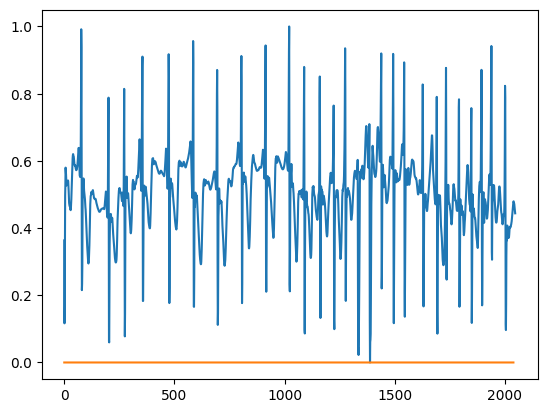

In [5]:
new_fp = np.memmap('Dataset/MIT_BIH0_signals_Normal.dat', dtype=np.float32, mode='r', shape=(34370,1,2048))
new_fp_l = np.memmap('Dataset/MIT_BIH0_labels_Normal.dat', dtype=np.float32, mode='r', shape=(34370,1, 2040))

# Reading values
plt.plot(new_fp[1,0,:])
plt.plot(new_fp_l[1,0,:])